In [1]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class QNetwork:
    
    def __init__(self):
        
        self.gamma = 0.99
        self.epsilon = 0.1
        
        self._build_net()

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def _build_net(self):
        
        with tf.name_scope('inputs'):
            self.tf_obs = tf.placeholder(tf.float32, [1, 16], name="observation")
            
#         hidden_layer = tf.layers.dense(
#             inputs=self.tf_obs,
#             units=10,
#             activation=tf.nn.tanh,
#             kernel_initializer=tf.random_uniform_initializer(minval=0, maxval=0.01)
#         )
        
#         self.Qout = tf.layers.dense(
#             inputs=hidden_layer,
#             units=4,
#             activation=None,
#             kernel_initializer=tf.random_uniform_initializer(minval=0, maxval=0.01)
#         )
        
#         self.Qout = tf.layers.dense(
#             inputs=self.tf_obs,
#             units=4,
#             activation=tf.nn.sigmoid,
#             kernel_initializer=tf.random_uniform_initializer(minval=0, maxval=0.01),
#         )
        
        W = tf.Variable(tf.random_uniform([16,4], minval=0, maxval=0.01))
        self.Qout = tf.matmul(self.tf_obs, W)
        self.predict_act = tf.argmax(self.Qout, axis=1)

        with tf.name_scope('loss'):
            self.updatedQ = tf.placeholder(shape=[1,4], dtype=tf.float32)            
            loss = tf.reduce_sum(tf.square(self.updatedQ - self.Qout))
          
        with tf.name_scope('train'):
            self.train_op = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
            
    def one_hot(self, ix, n):
        vec = np.zeros(n)
        vec[ix] = 1
        return vec.reshape(1,n)
        
    def choice_action(self, observation):
        
        obs = self.one_hot(observation, 16)
        
        action = self.sess.run(self.predict_act, feed_dict={self.tf_obs: obs})[0]
        
        if np.random.rand() < self.epsilon:
            action = env.action_space.sample()
        
        return action
       
        
    def _predict_qval(self, obs):
        pred_Q = self.sess.run(self.Qout, feed_dict={self.tf_obs: obs}) # dim -> (1,4)
        return pred_Q

    def learn(self, obs, act, rs, next_obs):        
        
        obs = self.one_hot(obs, 16)
        next_obs = self.one_hot(next_obs, 16)
        
        Q = self._predict_qval(obs)
        nextQ = self._predict_qval(next_obs)
        max_nextQ = np.max(nextQ)
        
        #update current (s,a) q_val
        Q[0, act] = rs + (self.gamma * max_nextQ)
        
        self.sess.run(self.train_op, feed_dict={self.updatedQ: Q, self.tf_obs: obs})


In [3]:
env = gym.make('FrozenLake-v0')

INFO:gym.envs.registration:Making new env: FrozenLake-v0
[2017-05-01 10:57:22,826] Making new env: FrozenLake-v0


In [4]:
qnet = QNetwork()

In [5]:
num_episodes = 2000
max_steps = 100

R_list = []

for i_episode in xrange(num_episodes):
    s = time()
    
    observ = env.reset()
    
    
    for i_step in xrange(max_steps):
               
        action = qnet.choice_action(observ)
      
        next_observ, reward, done, info = env.step(action)
#         if done and reward != 1:
#             reward = -1
        
        if 'running_reward' not in globals():
            running_reward = reward
        else:
            running_reward = 0.99*running_reward + 0.01*reward
                                   
        qnet.learn(observ, action, reward, next_observ)
       
        if done:
            
            if i_episode % 50 == 0:
                print(" episode:", i_episode, 
                      " running rewards:", round(running_reward,3), 
                      " total steps:", i_step, 
                      " waste time:", round(time()-s, 3))
            #Reduce chance of random action as we train the model.
            qnet.epsilon = 1./((i_episode/50) + 10)
            R_list.append(reward)
            break
            
        observ = next_observ


(' episode:', 0, ' running rewards:', 0.0, ' total steps:', 6, ' waste time:', 0.028)
(' episode:', 50, ' running rewards:', 0.0, ' total steps:', 3, ' waste time:', 0.009)
(' episode:', 100, ' running rewards:', 0.002, ' total steps:', 2, ' waste time:', 0.007)
(' episode:', 150, ' running rewards:', 0.007, ' total steps:', 3, ' waste time:', 0.01)
(' episode:', 200, ' running rewards:', 0.015, ' total steps:', 3, ' waste time:', 0.009)
(' episode:', 250, ' running rewards:', 0.008, ' total steps:', 1, ' waste time:', 0.004)
(' episode:', 300, ' running rewards:', 0.003, ' total steps:', 3, ' waste time:', 0.01)
(' episode:', 350, ' running rewards:', 0.005, ' total steps:', 8, ' waste time:', 0.023)
(' episode:', 400, ' running rewards:', 0.017, ' total steps:', 16, ' waste time:', 0.038)
(' episode:', 450, ' running rewards:', 0.001, ' total steps:', 19, ' waste time:', 0.041)
(' episode:', 500, ' running rewards:', 0.01, ' total steps:', 2, ' waste time:', 0.007)
(' episode:', 550,

In [6]:
num_success = sum(np.array(R_list) == 1)
print("Percent of succesful episodes: ", 1.0 *  num_success/num_episodes)


('Percent of succesful episodes: ', 0.329)


/Users/apple/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=500,center=False).mean()
  if __name__ == '__main__':


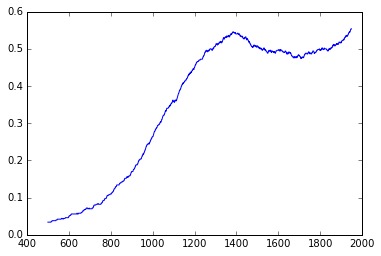

In [7]:
plt.plot(pd.rolling_mean(pd.Series(R_list), window=500))

# Reference
1. [Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)
2. [Tensorflow tutorial](https://github.com/nlintz/TensorFlow-Tutorials)